# Customer Segmentation

In [123]:
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
print("Setup Complete")

Setup Complete


In [124]:
df = pd.read_csv('data/marketing_campaign.csv', sep='\t')

In [125]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


## Data Cleaning


__Attributes__:

People
- `ID`: Customer's unique identifier
- `Year_Birth`: Customer's birth year
- `Education`: Customer's education level
- `Marital_Status`: Customer's marital status
- `Income`: Customer's yearly household income
- `Kidhome`: Number of children in customer's household
- `Teenhome`: Number of teenagers in customer's household
- `Dt_Customer`: Date of customer's enrollment with the company
- `Recency`: Number of days since customer's last purchase
- `Complain`: 1 if the customer complained in the last 2 years, 0 otherwise

Products

- `MntWines`: Amount spent on wine in last 2 years
- `MntFruits`: Amount spent on fruits in last 2 years
- `MntMeatProducts`: Amount spent on meat in last 2 years
- `MntFishProducts`: Amount spent on fish in last 2 years
- `MntSweetProducts`: Amount spent on sweets in last 2 years
- `MntGoldProds`: Amount spent on gold in last 2 years

Promotion

- `NumDealsPurchases`: Number of purchases made with a discount
- `AcceptedCmp1`: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
- `AcceptedCmp2`: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
- `AcceptedCmp3`: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
- `AcceptedCmp4`: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
- `AcceptedCmp5`: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
- `Response`: 1 if customer accepted the offer in the last campaign, 0 otherwise

Place

- `NumWebPurchases`: Number of purchases made through the company’s website
- `NumCatalogPurchases`: Number of purchases made using a catalogue
- `NumStorePurchases`: Number of purchases made directly in stores
- `NumWebVisitsMonth`: Number of visits to company’s website in the last month


In [126]:
print('Number of missing entries:', pd.isnull(df).sum().sum())
# Drop rows with missing entries
df = df.dropna()

Number of missing entries: 24


It appears as if `Z_CostContact` and `Z_Revenue` all have values equal to zero, so we will drop these columns

In [127]:
df = df.drop(['Z_CostContact', 'Z_Revenue'], axis=1)

### Categorical Data

In [128]:
print('Categorical/String Columns:')
df.dtypes[df.dtypes == 'object']

Categorical/String Columns:


Education         object
Marital_Status    object
Dt_Customer       object
dtype: object

In [129]:
df['Marital_Status'].value_counts()

Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

In [130]:
df['Marital_Status'] = df['Marital_Status'].replace('Alone', 'Single')
# drop absurd and yolo
df = df.drop(df.index[df['Marital_Status'] == 'Absurd'], axis=0)
df = df.drop(df.index[df['Marital_Status'] == 'YOLO'], axis=0)

It is unclear what absurd and YOLO mean, so we can drop them

Now we shall investigate education level

In [131]:
df['Education'].value_counts()

Graduation    1115
PhD            479
Master         364
2n Cycle       200
Basic           54
Name: Education, dtype: int64

### Numerical Data

What is the range of dates the customers registered?

In [132]:
df['Dt_Customer'] = df['Dt_Customer'].astype('datetime64')
print('Latest dt registered:', df['Dt_Customer'].max())
print('Earliest dt registered:', df['Dt_Customer'].min())

Latest dt registered: 2014-12-06 00:00:00
Earliest dt registered: 2012-01-08 00:00:00


In [133]:
latest_reg = df['Dt_Customer'].max()
print('Latest year:', latest_reg.year)

Latest year: 2014


In [134]:
df['Days_Registered'] = pd.to_numeric(-df['Dt_Customer'] + latest_reg)
df = df.drop('Dt_Customer', axis=1)

We also need to convert customer birth year to current age at the time of recording

In [135]:
df['Age'] = -(df['Year_Birth']) + latest_reg.year
df = df.drop('Year_Birth', axis=1)

In [136]:
df

,ID,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Days_Registered,Age
0,5524,Graduation,Single,58138.0,0,0,58,635,88,546,...,7,0,0,0,0,0,0,1,971 days,57
1,2174,Graduation,Single,46344.0,1,1,38,11,1,6,...,5,0,0,0,0,0,0,0,125 days,60
2,4141,Graduation,Together,71613.0,0,0,26,426,49,127,...,4,0,0,0,0,0,0,0,472 days,49
3,6182,Graduation,Together,26646.0,1,0,26,11,4,20,...,6,0,0,0,0,0,0,0,65 days,30
4,5324,PhD,Married,58293.0,1,0,94,173,43,118,...,5,0,0,0,0,0,0,0,321 days,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,Graduation,Married,61223.0,0,1,46,709,43,182,...,5,0,0,0,0,0,0,0,541 days,47
2236,4001,PhD,Together,64014.0,2,1,56,406,0,30,...,7,0,0,0,1,0,0,0,61 days,68
2237,7270,Graduation,Divorced,56981.0,0,0,91,908,48,217,...,6,0,1,0,0,0,0,0,315 days,33
2238,8235,Master,Together,69245.0,0,1,8,428,30,214,...,3,0,0,0,0,0,0,0,316 days,58


## Data Visualization

## K-Means Clustering

In [138]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
temp_df = df.drop(['Education', 'Marital_Status', 'ID'], axis=1)
num_cols = temp_df.columns

from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
temp_df = pd.DataFrame(standard_scaler.fit_transform(temp_df), columns = num_cols)
                  
clusters = kmeans.fit_predict(temp_df)

C:\Users\Claudeon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [139]:
temp_df

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Days_Registered,Age
0,0.234515,-0.824288,-0.92886,0.309300,0.977586,1.550693,1.689878,2.465495,1.483638,0.855961,...,0.693355,-0.282048,-0.282981,-0.280175,-0.260927,-0.117256,-0.097901,2.383858,1.976831,0.985949
1,-0.233840,1.038148,0.90892,-0.381922,-0.871112,-0.636731,-0.717674,-0.651121,-0.634018,-0.732823,...,-0.132103,-0.282048,-0.282981,-0.280175,-0.260927,-0.117256,-0.097901,-0.419488,-1.665739,1.236380
2,0.769624,-0.824288,-0.92886,-0.796656,0.358390,0.570123,-0.178204,1.347180,-0.147201,-0.035308,...,-0.544832,-0.282048,-0.282981,-0.280175,-0.260927,-0.117256,-0.097901,-0.419488,-0.171682,0.318133
3,-1.016073,1.038148,-0.92886,-0.796656,-0.871112,-0.561303,-0.655256,-0.504457,-0.585336,-0.752199,...,0.280626,-0.282048,-0.282981,-0.280175,-0.260927,-0.117256,-0.097901,-0.419488,-1.924077,-1.267929
4,0.240670,1.038148,-0.92886,1.553500,-0.391162,0.419267,-0.218330,0.155532,-0.001155,-0.558445,...,-0.132103,-0.282048,-0.282981,-0.280175,-0.260927,-0.117256,-0.097901,-0.419488,-0.821834,-1.017498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,0.357024,-0.824288,0.90892,-0.105433,1.196822,0.419267,0.067009,0.082200,2.213864,3.936651,...,-0.132103,-0.282048,-0.282981,-0.280175,-0.260927,-0.117256,-0.097901,-0.419488,0.125407,0.151179
2208,0.467858,2.900585,0.90892,0.240178,0.299137,-0.661874,-0.610672,-0.687787,-0.658359,-0.694073,...,0.693355,-0.282048,-0.282981,-0.280175,3.832485,-0.117256,-0.097901,-0.419488,-1.941300,1.904195
2209,0.188569,-0.824288,-0.92886,1.449817,1.786391,0.544981,0.223054,-0.101130,-0.366268,-0.384066,...,0.280626,-0.282048,3.533809,-0.280175,-0.260927,-0.117256,-0.097901,-0.419488,-0.847668,-1.017498
2210,0.675588,-0.824288,0.90892,-1.418756,0.364316,0.092410,0.209679,0.778856,0.071867,0.332824,...,-0.957561,-0.282048,-0.282981,-0.280175,-0.260927,-0.117256,-0.097901,-0.419488,-0.843362,1.069426


<AxesSubplot:>

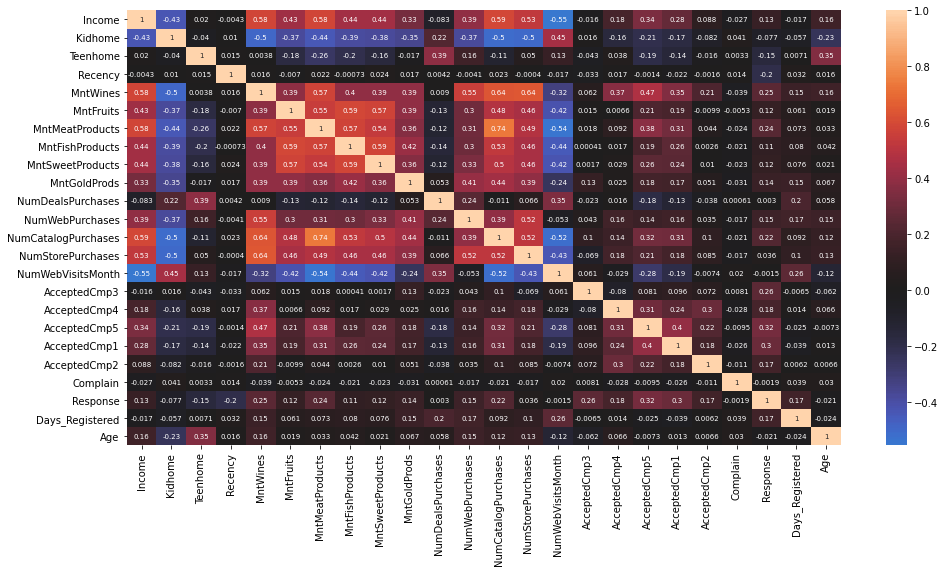

In [149]:
plt.figure(figsize=(16,8))
sns.heatmap(temp_df.corr(),annot=True, annot_kws={'size':7}, center=0)

## Principal Component Analysis

In [141]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(temp_df)

In [142]:
pca.explained_variance_ratio_

array([0.27279778, 0.08689426, 0.07975497, 0.06452854, 0.04777812,
       0.04263395, 0.04172779, 0.03663332, 0.03519727, 0.03128912,
       0.0306329 , 0.02545282, 0.02494833, 0.02383365, 0.02271282,
       0.02143821, 0.01899512, 0.01781307, 0.01702371, 0.01561426,
       0.01301137, 0.01146876, 0.00971472, 0.00810515])

In [143]:
pd.DataFrame(X_pca)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,3.853590,0.655051,0.009597,2.912914,-0.175338,0.234586,0.584388,-1.221461,-1.804177,0.757574,...,1.119447,-0.352483,-0.298205,0.680541,1.029958,0.806119,-0.338144,0.053100,-0.714268,0.216352
1,-2.440610,-0.358974,-0.450058,-1.781813,1.292669,-0.033750,-0.041111,0.619922,-0.314563,0.732760,...,0.057880,0.226485,0.168064,0.138380,0.195170,0.035482,-0.328851,0.113265,-0.110714,0.006769
2,1.614513,-0.091097,-1.083634,-0.103634,0.209246,-0.703650,0.708116,-0.585841,0.711696,-0.220781,...,1.070036,0.319608,0.820773,-0.380877,-0.351023,0.732715,0.772151,-0.297223,-0.132826,0.055744
3,-2.589857,-1.761844,0.023874,-0.256539,0.118988,-0.879278,0.177184,1.049705,1.166665,-0.002278,...,0.557489,0.030468,-0.340040,-0.107305,-0.145184,0.113699,-0.120739,0.131436,-0.018311,-0.018986
4,-0.489026,-0.283518,-0.663752,0.487937,-1.418128,0.137500,-0.981704,1.711042,0.500789,0.032563,...,0.787569,-0.249658,0.120539,-0.243195,-0.130233,-0.063864,0.713756,-0.215709,-0.483599,0.028715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,2.389694,1.538441,-1.150402,0.989320,0.365524,-0.047708,-0.759256,-0.734957,0.857932,1.012969,...,-0.384621,-0.531486,0.246034,1.870281,0.514694,-0.921095,-0.917683,0.245099,-0.105894,-1.071531
2208,-1.032965,1.978697,1.244665,-1.263013,0.828390,0.031457,-0.799659,4.093747,-1.002641,2.753288,...,1.604466,0.830031,1.021947,-0.328760,-0.142006,-0.606935,-0.145832,-0.402281,-0.272122,-0.201310
2209,1.434290,-0.204207,0.816853,-1.738856,-2.568951,-0.190823,-0.290947,-0.076864,0.945764,-1.618519,...,-0.599287,0.363351,-0.002342,-1.302415,-0.759045,-0.291855,-0.490087,1.340247,0.083571,0.137453
2210,1.728700,0.828298,-1.307874,-1.111792,1.503204,-0.724665,0.680812,-0.066723,0.610073,-0.070167,...,0.196486,0.236842,0.005565,-0.049616,-0.286625,0.480125,-0.202583,-0.147495,-0.079405,0.382159


In [144]:
loadings = pd.DataFrame(pca.components_.T,
                        index=num_cols)
loadings

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Income,0.290908,0.035542,-0.047785,-0.162533,0.055055,-0.016264,0.019697,0.184465,-0.010722,-0.172989,...,-0.087410,-0.074324,0.641010,0.214539,0.145056,-0.082424,0.384849,0.319311,-0.024015,0.104395
Kidhome,-0.255588,-0.067602,0.103783,0.170634,-0.095221,-0.000669,-0.028013,0.440156,-0.001394,0.194128,...,0.058311,0.289593,0.464744,-0.014492,-0.156545,0.003376,-0.430601,-0.190686,-0.022987,0.043421
Teenhome,-0.055718,0.490635,-0.093582,-0.240549,0.228869,0.034624,-0.071606,0.084460,-0.001099,0.122870,...,-0.480925,-0.289518,-0.037779,-0.031264,0.185337,0.214951,-0.341390,-0.034681,0.108218,0.055386
Recency,0.000453,0.028234,-0.110516,-0.090502,-0.507640,0.475394,-0.576935,0.021877,-0.237881,0.006623,...,0.090295,-0.260129,0.032479,-0.076081,-0.059959,0.037805,0.027354,0.036547,-0.014320,0.014791
MntWines,0.306852,0.174942,0.171053,-0.073449,-0.077975,-0.004223,-0.015402,0.020512,0.006490,-0.235589,...,0.125698,0.178188,0.013590,-0.122628,0.027452,0.080184,-0.357818,0.314629,-0.314966,-0.605111
MntFruits,0.265765,-0.099914,-0.178205,0.173728,-0.021205,-0.018686,0.051538,-0.011663,0.079072,0.255440,...,-0.077551,-0.006649,0.052190,-0.584728,0.414131,-0.297720,0.057746,-0.064845,-0.101762,-0.013570
MntMeatProducts,0.314569,-0.122106,-0.038227,0.075399,-0.039806,0.013163,0.027977,0.118374,-0.139287,-0.144715,...,0.104281,0.061044,-0.133743,0.035441,0.231550,0.015918,-0.204957,0.007258,0.757804,-0.109618
MntFishProducts,0.275882,-0.107818,-0.175278,0.163892,-0.038515,-0.023098,0.034018,-0.036037,0.016870,0.335316,...,-0.081348,0.147380,0.053611,0.027196,-0.064718,0.797416,0.134469,0.039110,-0.067053,-0.007958
MntSweetProducts,0.269485,-0.089684,-0.147529,0.143931,-0.071778,-0.020026,0.021512,0.034637,0.010328,0.308744,...,-0.069521,-0.064699,-0.219544,0.565258,-0.237894,-0.306089,-0.140252,0.146906,-0.031434,-0.059082
MntGoldProds,0.221363,0.124875,-0.058107,0.228703,0.081920,0.046498,-0.202732,-0.138207,0.185515,0.173073,...,-0.185504,0.002562,0.132750,0.074684,-0.062443,-0.138513,-0.088738,0.099482,0.084100,-0.012737


<AxesSubplot:>

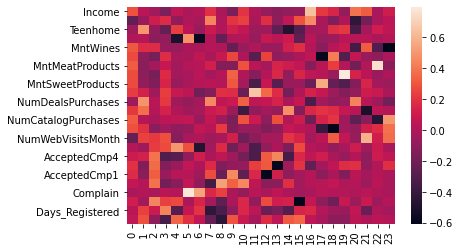

In [145]:
sns.heatmap(loadings)

<AxesSubplot:>

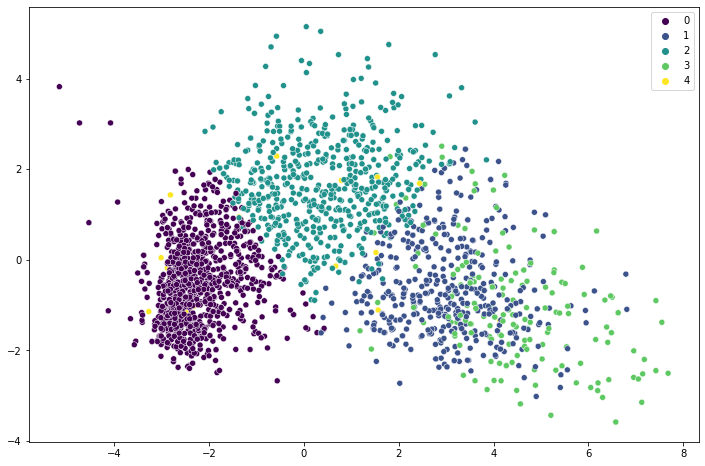

In [146]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], 
                hue=clusters, 
                palette='viridis'
                )
# plt.xlim(0,200000)
# plt.ylim(0,80)